In [2]:
%load_ext autoreload   
%autoreload 2

In [10]:
import os
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.auto import trange
from contextlib import redirect_stdout
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.cv2_eval_utils import evaluate_pipeline_on_prompts, print_evaluation_summary
from utils.relation_shape_dataset_lib import ShapesDataset
from utils.variance_partition_with_effects import variance_partition_with_effects#, variance_partition
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.pixart_utils import construct_diffuser_pipeline_from_config, PixArt_model_configs
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

In [ ]:
# Load the two CSVs into pandas DataFrames
df_subset = pd.read_csv("/n/home12/binxuwang/Github/DiffusionObjectRelation/Tables/per_prompt_accuracies_subset.csv")
df_full = pd.read_csv("/n/home12/binxuwang/Github/DiffusionObjectRelation/Tables/per_prompt_accuracies.csv")
# Show the DataFrames
print("Subset accuracies:")
display(df_subset)
print("Full accuracies:")
display(df_full)

Subset accuracies:


,prompt_id,prompt,n_images,num_objects_acc,n_num_objects_correct,n_num_relation_is_correct,relation_acc_cond_on_num_objects_correct
0,0,A cat is on the left of a dog.,100,36.0,36,32,88.89
1,1,A dog is on the right of a cat.,100,30.0,30,12,40.00
2,2,A cat is on the right of a dog.,100,37.0,37,12,32.43
3,3,A dog is on the left of a cat.,100,31.0,31,11,35.48
4,4,A human is on the left of a dog.,100,43.0,43,12,27.91
5,5,A dog is on the right of a human.,100,65.0,65,29,44.62
6,6,A human is on the right of a dog.,100,44.0,44,11,25.00
7,7,A dog is on the left of a human.,100,73.0,73,73,100.00
8,8,A human is on the left of a cat.,100,27.0,27,3,11.11
9,9,A cat is on the right of a human.,100,51.0,51,27,52.94


Full accuracies:


,prompt_id,prompt,n_images,num_objects_acc,n_num_objects_correct,n_num_relation_is_correct,relation_acc_cond_on_num_objects_correct
0,0,A cat is on the left of a dog.,20,40.0,8,7,87.50
1,1,A dog is on the right of a cat.,20,25.0,5,3,60.00
2,2,A cat is on the right of a dog.,20,30.0,6,2,33.33
3,3,A dog is on the left of a cat.,20,25.0,5,2,40.00
4,4,An apple is on the left of a banana.,20,35.0,7,5,71.43
...,...,...,...,...,...,...,...
115,115,A suitcase is on the left of a backpack.,20,5.0,1,0,0.00
116,116,A cookie is on the left of a donut.,20,10.0,2,0,0.00
117,117,A donut is on the right of a cookie.,20,15.0,3,2,66.67
118,118,A cookie is on the right of a donut.,20,5.0,1,1,100.00


In [8]:
display(df_subset.mean(numeric_only=True))

prompt_id                                    11.500000
n_images                                    100.000000
num_objects_acc                              47.166667
n_num_objects_correct                        47.166667
n_num_relation_is_correct                    26.916667
relation_acc_cond_on_num_objects_correct     53.811250
dtype: float64

In [9]:
display(df_full.mean(numeric_only=True))

prompt_id                                   59.500000
n_images                                    20.000000
num_objects_acc                             22.750000
n_num_objects_correct                        4.550000
n_num_relation_is_correct                    2.500000
relation_acc_cond_on_num_objects_correct    56.436747
dtype: float64

In [5]:
# https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/pixart_alpha/pipeline_pixart_sigma.py
import torch
from diffusers import Transformer2DModel, PixArtSigmaPipeline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.float16
transformer = Transformer2DModel.from_pretrained(
    # "PixArt-alpha/PixArt-Sigma-XL-2-256x256", 
    "PixArt-alpha/PixArt-Sigma-XL-2-512-MS",
    subfolder='transformer', 
    torch_dtype=weight_dtype,
    use_safetensors=True,
)
pipe = PixArtSigmaPipeline.from_pretrained(
    "PixArt-alpha/pixart_sigma_sdxlvae_T5_diffusers",
    transformer=transformer,
    torch_dtype=weight_dtype,
    use_safetensors=True,
)
pipe.to(device)


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/si

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

transformer/diffusion_pytorch_model.safe(…):   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

text_encoder/model-00002-of-00002.safete(…):   0%|          | 0.00/9.06G [00:00<?, ?B/s]

text_encoder/model-00001-of-00002.safete(…):   0%|          | 0.00/9.99G [00:00<?, ?B/s]

tokenizer/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


PixArtSigmaPipeline {
  "_class_name": "PixArtSigmaPipeline",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "PixArt-alpha/pixart_sigma_sdxlvae_T5_diffusers",
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "transformer": [
    "diffusers",
    "PixArtTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
seed = 1
generator = torch.Generator(device="cuda").manual_seed(seed)

# prompt = "an apple on the right of a cup"
# prompt = "a dog is on the left of a cat"
# prompt = "a dog is on the right of a human"
# prompt = "a dog is on the left of a human"
# prompt = "a horse is on the left of a tree"
# prompt = "an apple is on the right of a banana"
# prompt = "a cat is on the left side of an apple"
# prompt = "a dog is on the left of a chair"
prompt = "a dog is to the right of a chair"
with torch.no_grad():
    images = pipe(prompt=prompt, generator=generator, num_images_per_prompt=20, height=256, width=256).images
for img in images:
    display(img)

In [18]:
from experimental_scripts.generalization_profile_eval_cli import evaluate_pipeline_on_prompts_with_cached_embeddings, precompute_embeddings
def find_shape_index(tokens, shape):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = shape.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = shape.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

def find_word_index(tokens, word):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = word.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = word.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [25]:
import re

def _clean_piece(tok: str) -> str:
    # Remove common boundary markers and wordpiece prefixes
    t = tok.strip()
    t = t.replace("▁", "").replace("Ġ", "")
    if t.startswith("##"):
        t = t[2:]
    return t

def _is_special(tok: str) -> bool:
    t = tok.strip()
    if t == "" or t.lower() in {"</s>", "<pad>", "<s>", "<unk>"}:
        return True
    # optionally treat anything like <...> as special
    if re.match(r"^<[^>]+>$", t):
        return True
    return False

def find_word_span_concat(tokens, word):
    """
    Find (start_idx, end_idx) (inclusive) for `word` by concatenating token pieces.
    Works for cases like ["for","k"] -> "fork" and subword tokenizers.
    """
    target = word.strip().lower()
    if not target:
        return None

    n = len(tokens)
    for i in range(n):
        if _is_special(tokens[i]):
            continue

        acc = ""
        for j in range(i, n):
            if _is_special(tokens[j]):
                break  # stop span at specials/empties

            piece = _clean_piece(tokens[j]).lower()
            if piece == "":
                break

            acc += piece

            # pruning
            if len(acc) > len(target):
                break

            if acc == target:
                return (i, j)

    return None

def find_last_token_of_word(tokens, word):
    span = find_word_span_concat(tokens, word)
    return None if span is None else span[1]

In [ ]:
import re

def parse_spatial_prompt(prompt):
    """
    Parse prompts like:
      - "A cat is on the left of a dog."
      - "small red cube to the right of the blue sphere"
    Returns dict with keys: object1, relation, object2
    """

    if not prompt:
        return None

    # --- normalize ---
    p = prompt.lower().strip()
    p = p.rstrip(".?!")
    p = " ".join(p.split())  # normalize whitespace

    # --- canonicalize relation phrases ---
    replacements = {
        "on the left side of": " left_of ",
        "to the left of": " left_of ",
        "on the left of": " left_of ",
        "left of": " left_of ",
        "on the right side of": " right_of ",
        "to the right of": " right_of ",
        "on the right of": " right_of ",
        "right of": " right_of ",
    }

    for k, v in replacements.items():
        p = p.replace(k, v)

    # --- split on relation token ---
    if " left_of " in p:
        obj1, obj2 = p.split(" left_of ", 1)
        relation = "left"
    elif " right_of " in p:
        obj1, obj2 = p.split(" right_of ", 1)
        relation = "right"
    else:
        return None

    # --- remove verbs and articles from object1 ---
    obj1 = obj1.replace(" is ", " ")
    obj1 = obj1.replace(" are ", " ")

    articles = {"a", "an", "the", "this", "that", "these", "those", "some"}
    obj1_words = [w for w in obj1.split() if w not in articles]
    obj2_words = [w for w in obj2.split() if w not in articles]

    object1 = " ".join(obj1_words).strip()
    object2 = " ".join(obj2_words).strip()

    if not object1 or not object2:
        return None

    return {
        "object1": object1,
        "relation": relation,
        "object2": object2,
    }

# Example use, create a new DataFrame column for object1, relation, object2
# Assumes df_full is already loaded and has a 'prompt' column
df_full[["object1", "relation", "object2"]] = df_full["prompt"].apply(
    lambda p: pd.Series(parse_spatial_prompt(p))
)
df_subset[["object1", "relation", "object2"]] = df_subset["prompt"].apply(
    lambda p: pd.Series(parse_spatial_prompt(p))
)

In [26]:
tokens = ['A','spoon','is','on','the','left','of','','a','for','k','.', '</s>', '<pad>']
print(find_word_span_concat(tokens, "fork"))        # (9, 10)
print(find_last_token_of_word(tokens, "fork"))      # 10

(9, 10)
10


In [28]:
# dataset_tmp = ShapesDataset(num_images=10000)
# prompt_collection_all, scene_info_collection_all = generate_all_prompt_collection(dataset_tmp.spatial_phrases,
#                                 prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",)
with torch.no_grad():
    embedding_allrel_allobj = precompute_embeddings({"base":(df_full["prompt"], df_full[["object1", "relation", "object2"]])}, 
                                        pipe.tokenizer, pipe.text_encoder, 
                                        max_sequence_length=20, device="cuda")
prompt_scene_info_all_df = df_full
prompt_scene_info_all_df
wordvec_obj1_col = []
wordvec_obj2_col = []
wordvec_relation_col = []
for row in prompt_scene_info_all_df.itertuples():
    tokenized = pipe.tokenizer(row.prompt, max_length=20, padding="max_length", truncation=True, return_tensors="pt")
    token_ids = tokenized['input_ids'][0]
    tokens = [pipe.tokenizer.decode([token_id]) for token_id in token_ids]
    
    shape1_mask_idx = find_shape_index(tokens, row.object1)
    if shape1_mask_idx is None:
        print(f"Shape1 ({row.object1}) not found in prompt")
        shape1_mask_idx = find_last_token_of_word(tokens, row.object1)
    shape2_mask_idx = find_shape_index(tokens, row.object2)
    if shape2_mask_idx is None:
        print(f"Shape2 ({row.object2}) not found in prompt")
        shape2_mask_idx = find_last_token_of_word(tokens, row.object2)
    relation_mask_idx = find_shape_index(tokens, row.relation)
    if relation_mask_idx is None:
        print(f"Relation ({row.relation}) not found in prompt")
        relation_mask_idx = find_last_token_of_word(tokens, row.relation)
    if shape1_mask_idx is None or shape2_mask_idx is None or relation_mask_idx is None:
        print(f"Prompt: {row.prompt}")
        print(f"Shape1 ({row.object1}) at index: {shape1_mask_idx}")
        print(f"Shape2 ({row.object2}) at index: {shape2_mask_idx}")
        print(f"Relation ({row.relation}) at index: {relation_mask_idx}")
        print("---")
        raise ValueError("Shape index not found")
    cap_embeds = embedding_allrel_allobj[f"base::{row.prompt}"]['caption_embeds']
    wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
    wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
    wordvec_relation_col.append(cap_embeds[0, relation_mask_idx, :])
wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)
wordvec_relation_mat = torch.stack(wordvec_relation_col, dim=0)
with torch.no_grad():
    wordvec_obj1_mat_proj = pipe.transformer.caption_projection(wordvec_obj1_mat.half().cuda())
    wordvec_obj2_mat_proj = pipe.transformer.caption_projection(wordvec_obj2_mat.half().cuda())
    wordvec_relation_mat_proj = pipe.transformer.caption_projection(wordvec_relation_mat.half().cuda())

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/121 [00:00<?, ?it/s]

Cached embeddings for 121 unique prompts (including uncond)
Shape2 (fork) not found in prompt
Shape1 (fork) not found in prompt
Shape2 (fork) not found in prompt
Shape1 (fork) not found in prompt
Shape2 (sock) not found in prompt
Shape1 (sock) not found in prompt
Shape2 (sock) not found in prompt
Shape1 (sock) not found in prompt
Shape2 (zebra) not found in prompt
Shape1 (zebra) not found in prompt
Shape2 (zebra) not found in prompt
Shape1 (zebra) not found in prompt
Shape2 (donut) not found in prompt
Shape1 (donut) not found in prompt
Shape2 (donut) not found in prompt
Shape1 (donut) not found in prompt


In [29]:
prompt_scene_info_all_df

,prompt_id,prompt,n_images,num_objects_acc,n_num_objects_correct,n_num_relation_is_correct,relation_acc_cond_on_num_objects_correct,object1,relation,object2
0,0,A cat is on the left of a dog.,20,40.0,8,7,87.50,cat,left,dog
1,1,A dog is on the right of a cat.,20,25.0,5,3,60.00,dog,right,cat
2,2,A cat is on the right of a dog.,20,30.0,6,2,33.33,cat,right,dog
3,3,A dog is on the left of a cat.,20,25.0,5,2,40.00,dog,left,cat
4,4,An apple is on the left of a banana.,20,35.0,7,5,71.43,apple,left,banana
...,...,...,...,...,...,...,...,...,...,...
115,115,A suitcase is on the left of a backpack.,20,5.0,1,0,0.00,suitcase,left,backpack
116,116,A cookie is on the left of a donut.,20,10.0,2,0,0.00,cookie,left,donut
117,117,A donut is on the right of a cookie.,20,15.0,3,2,66.67,donut,right,cookie
118,118,A cookie is on the right of a donut.,20,5.0,1,1,100.00,cookie,right,donut


In [32]:
len(prompt_scene_info_all_df.object1.unique())

60

In [33]:
len(prompt_scene_info_all_df.object2.unique())

60

In [42]:
def get_left_object(row):
    # Handles both 'left' and 'right' relations appropriately by switching object1/object2.
    if str(row["relation"]).strip().lower() == "left":
        return f"{row['object1']}"
    elif str(row["relation"]).strip().lower() == "right":
        return f"{row['object2']}"
    else:
        raise ValueError(f"Relation {row['relation']} not supported")
def get_right_object(row):
    # Handles both 'left' and 'right' relations appropriately by switching object1/object2.
    if str(row["relation"]).strip().lower() == "left":
        return f"{row['object2']}"
    elif str(row["relation"]).strip().lower() == "right":
        return f"{row['object1']}"
prompt_scene_info_all_df["left_object"] = prompt_scene_info_all_df.apply(get_left_object, axis=1)
prompt_scene_info_all_df["right_object"] = prompt_scene_info_all_df.apply(get_right_object, axis=1)

In [ ]:
print("shape2, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "left_object": prompt_scene_info_all_df["left_object"],
             "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

shape2, T5 embedding, caption projection
Total R2 (all features): 0.995909
Total R² (all features): 0.9959


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,29,2794.657179,1.019199,0.000365,1.019199e+00,3.646956e-04,8.185019e-02,0.009901
1,object2,60,59,29,2794.657179,2772.800203,0.992179,4.041123e-13,1.446018e-16,3.534672e-14,1.000000
2,right_object,60,59,29,2794.657179,1644.396762,0.588407,2.924920e-13,1.046612e-16,2.558357e-14,1.000000
3,left_object,60,59,29,2794.657179,1644.396762,0.588407,2.789992e-13,9.983306e-17,2.440338e-14,1.000000
4,object1,60,59,29,2794.657179,2772.800203,0.992179,1.646008e-13,5.889840e-17,1.439724e-14,1.000000


In [44]:
print("shape2, T5 embedding")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "left_object": prompt_scene_info_all_df["left_object"],
             "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

shape2, T5 embedding
Total R2 (all features): 0.989400
Total R² (all features): 0.9894


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,29,3571.804204,7.536458,0.002110,7.536458e+00,2.109986e-03,1.660119e-01,0.009901
1,object2,60,59,29,3571.804204,3500.564552,0.980055,4.303764e-13,1.204927e-16,1.136738e-14,1.000000
2,right_object,60,59,29,3571.804204,2143.392342,0.600087,3.603150e-13,1.008776e-16,9.516877e-15,1.000000
3,left_object,60,59,29,3571.804204,2143.392342,0.600087,3.449818e-13,9.658474e-17,9.111886e-15,1.000000
4,object1,60,59,29,3571.804204,3500.564552,0.980055,2.007002e-13,5.619014e-17,5.301025e-15,1.000000


In [ ]:
print("object 1, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj1_mat_proj.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "left_object": prompt_scene_info_all_df["left_object"],
             "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.995690
Total R² (all features): 0.9957


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,29,2620.900117,1.025342,0.000391,1.025342e+00,3.912175e-04,8.321367e-02,0.009901
1,object2,60,59,29,2620.900117,2600.073112,0.992053,3.379959e-13,1.289618e-16,2.992052e-14,1.000000
2,right_object,60,59,29,2620.900117,1592.466666,0.607603,1.840920e-13,7.023997e-17,1.629643e-14,1.000000
3,left_object,60,59,29,2620.900117,1592.466666,0.607603,1.767246e-13,6.742897e-17,1.564425e-14,1.000000
4,object1,60,59,29,2620.900117,2600.073112,0.992053,7.206030e-14,2.749448e-17,6.379018e-15,1.000000


In [40]:
print("object 2, T5 embedding")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
            #  "left_object": prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

object 2, T5 embedding
Total R2 (all features): 0.982165
Total R² (all features): 0.9822


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,59,3571.804204,7.536458,0.002110,7.536458e+00,2.109986e-03,1.057902e-01,0.009901
1,object2,60,59,59,3571.804204,3500.564552,0.980055,-3.864987e-14,-1.082082e-17,-6.067179e-16,1.000000
2,object1,60,59,59,3571.804204,3500.564552,0.980055,-3.738934e-13,-1.046791e-16,-5.869303e-15,1.000000


In [41]:
print("object 2, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
            #  "left_object": prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

object 2, T5 embedding, caption projection
Total R2 (all features): 0.992544
Total R² (all features): 0.9925


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,59,2794.657179,1.019199,0.000365,1.019199e+00,3.646956e-04,4.663038e-02,0.009901
1,object2,60,59,59,2794.657179,2772.800203,0.992179,-4.200640e-14,-1.503097e-17,-2.015877e-15,1.000000
2,object1,60,59,59,2794.657179,2772.800203,0.992179,-3.055321e-13,-1.093272e-16,-1.466241e-14,1.000000


### relation encoding

In [51]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_relation_mat_proj.float().cpu().numpy(),
            {
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "object1": prompt_scene_info_all_df["object1"],
             "left_object": prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.928477
Total R² (all features): 0.9285


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,29,511.256072,193.685972,0.378843,1.936860e+02,3.788434e-01,8.411888e-01,0.009901
1,left_object,60,59,29,511.256072,239.816922,0.469074,1.064323e+01,2.081781e-02,2.254447e-01,1.000000
2,object2,60,59,29,511.256072,270.360163,0.528816,6.283777e-14,1.229086e-16,1.718442e-15,1.000000
3,object1,60,59,29,511.256072,270.360163,0.528816,2.668435e-14,5.219372e-17,7.297445e-16,1.000000


In [52]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_relation_mat_proj.float().cpu().numpy(),
            {
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "object1": prompt_scene_info_all_df["object1"],
            #  "left_object": prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.907659
Total R² (all features): 0.9077


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,59,511.256072,193.685972,0.378843,1.936860e+02,3.788434e-01,8.040235e-01,0.009901
1,object2,60,59,59,511.256072,270.360163,0.528816,-5.357399e-16,-1.047890e-18,-1.134803e-17,1.000000
2,object1,60,59,59,511.256072,270.360163,0.528816,-3.748575e-14,-7.332088e-17,-7.940223e-16,1.000000


In [45]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_relation_mat.float().cpu().numpy(),
            {"object1": prompt_scene_info_all_df["object1"],
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "left_object": prompt_scene_info_all_df["left_object"],
             "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.929138
Total R² (all features): 0.9291


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,29,1007.682394,277.482222,0.275367,2.774822e+02,2.753667e-01,7.953313e-01,0.009901
1,object2,60,59,29,1007.682394,635.355118,0.630511,1.037973e-13,1.030059e-16,1.453609e-15,1.000000
2,right_object,60,59,29,1007.682394,555.077814,0.550846,6.734116e-14,6.682776e-17,9.430662e-16,1.000000
3,left_object,60,59,29,1007.682394,555.077814,0.550846,6.670068e-14,6.619217e-17,9.340967e-16,1.000000
4,object1,60,59,29,1007.682394,635.355118,0.630511,-5.825377e-15,-5.780966e-18,-8.158037e-17,1.000000


In [57]:
import numpy as np
import matplotlib.pyplot as plt
def ramp_alignment_metrics(M, dvec, eps=1e-12):
    """
    Returns:
      cosine     : [-1, 1] alignment with spatial direction (scale-free)
      projection : signed magnitude of alignment (units of M)
    """
    H, W = M.shape
    d = np.array(dvec)
    d = d / np.linalg.norm(d)
    
    # coordinate grid
    xs = np.linspace(-1, 1, W)
    ys = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(xs, ys)

    # ramp template
    T = d[0] * X + d[1] * Y
    T = T - T.mean()                      # remove DC (important!)
    T_norm = np.linalg.norm(T) + eps
    T_unit = T / T_norm                   # unit template

    # centered map
    # A = M.astype(float)
    A = M - M.mean()
    A_norm = np.linalg.norm(A) + eps

    # (1) signed projection magnitude
    projection = np.sum(A * T / T_norm)

    # (2) cosine / correlation
    cosine = projection / A_norm

    return dict(
        cosine=cosine,
        projection=projection,
        energy=A_norm,
        template_norm=T_norm,
    )


def visualize_direction_vectors(H=8, W=8):
    direction_vector = {
        'above': [0, -1],
        'below': [0, 1],
        'left': [-1, 0],
        'lower_left': [-1, 1],
        'lower_right': [1, 1],
        'right': [1, 0],
        'upper_left': [-1, -1],
        'upper_right': [1, -1]
    }

    # Visualize the template ramps in 2x4 subplots
    H, W = 8, 8  # set the dimensions of the grid (adjust if appropriate)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, (name, dvec) in enumerate(direction_vector.items()):
        xs = np.linspace(-1, 1, W)
        ys = np.linspace(-1, 1, H)
        X, Y = np.meshgrid(xs, ys)
        d = np.array(dvec)
        d = d / np.linalg.norm(d)
        T = d[0] * X + d[1] * Y
        T = T - T.mean()
        
        ax = axes[idx // 4, idx % 4]
        im = ax.imshow(T, cmap='coolwarm')
        ax.set_title(name)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# visualize_direction_vectors()
# inner_prod_mat[:, i_word:i_word+1].view(8, 8)
# plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
# plt.title(f"{levels_map['spatial_relationship'][i_word]}")
def eval_ramp_alignment_all(inner_prod_mat, spatial_relationship_levels, eps=1e-12, direction_vector=None, map_size=(8, 8)):
    if direction_vector is None:
        direction_vector = {
            # 'above': [0, -1],
            # 'below': [0, 1],
            'left': [-1, 0],
            # 'lower_left': [-1, 1],
            # 'lower_right': [1, 1],
            'right': [1, 0],
            # 'upper_left': [-1, -1],
            # 'upper_right': [1, -1]
        }

    i_word = 1
    align_dict_list = []
    for i_word in range(len(spatial_relationship_levels)):
        rel_name = spatial_relationship_levels[i_word]
        dvec = direction_vector[rel_name]
        align_dict = ramp_alignment_metrics(inner_prod_mat[:, i_word:i_word+1].view(map_size).detach().cpu().numpy(), dvec, eps=1e-12)
        align_dict["rel_name"] = rel_name
        align_dict["dvec"] = (dvec[0], dvec[1])
        align_dict["dir_idx"] = i_word
        align_dict_list.append(align_dict)
    # align_dict_list
    align_df = pd.DataFrame(align_dict_list)
    return align_df

In [ ]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_relation_mat_proj.float().cpu().numpy(),
            {
             "relation": prompt_scene_info_all_df["relation"],
             "object2": prompt_scene_info_all_df["object2"],
             "object1": prompt_scene_info_all_df["object1"],
            #  "left_object": prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

In [58]:
from tqdm import tqdm
from itertools import product
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

hidden_size = pipe.transformer.config["cross_attention_dim"]
head_num = pipe.transformer.config['num_attention_heads']
layer_num = pipe.transformer.config["num_layers"]
base_size = pipe.transformer.config['sample_size'] // pipe.transformer.config['patch_size']
head_dim = hidden_size // head_num
device = "cuda"
align_df_list = []
for layer_idx, head_idx in tqdm(product(range(layer_num), range(head_num))):
    target_embedding_direction = effect_vecs["relation"][:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipe.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipe.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
    align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["relation"], map_size=(base_size, base_size))
    align_df["layer_idx"] = layer_idx
    align_df["head_idx"] = head_idx
    align_df_list.append(align_df)
align_df_allheads = pd.concat(align_df_list)

448it [00:06, 72.57it/s]


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/PixArt_Sigma512_pretrained_attn_head_finding"
# figdir = join(figroot, model_run_name)
os.makedirs(figdir, exist_ok=True)
model_run_name = "PixArt_Sigma512_pretrained"

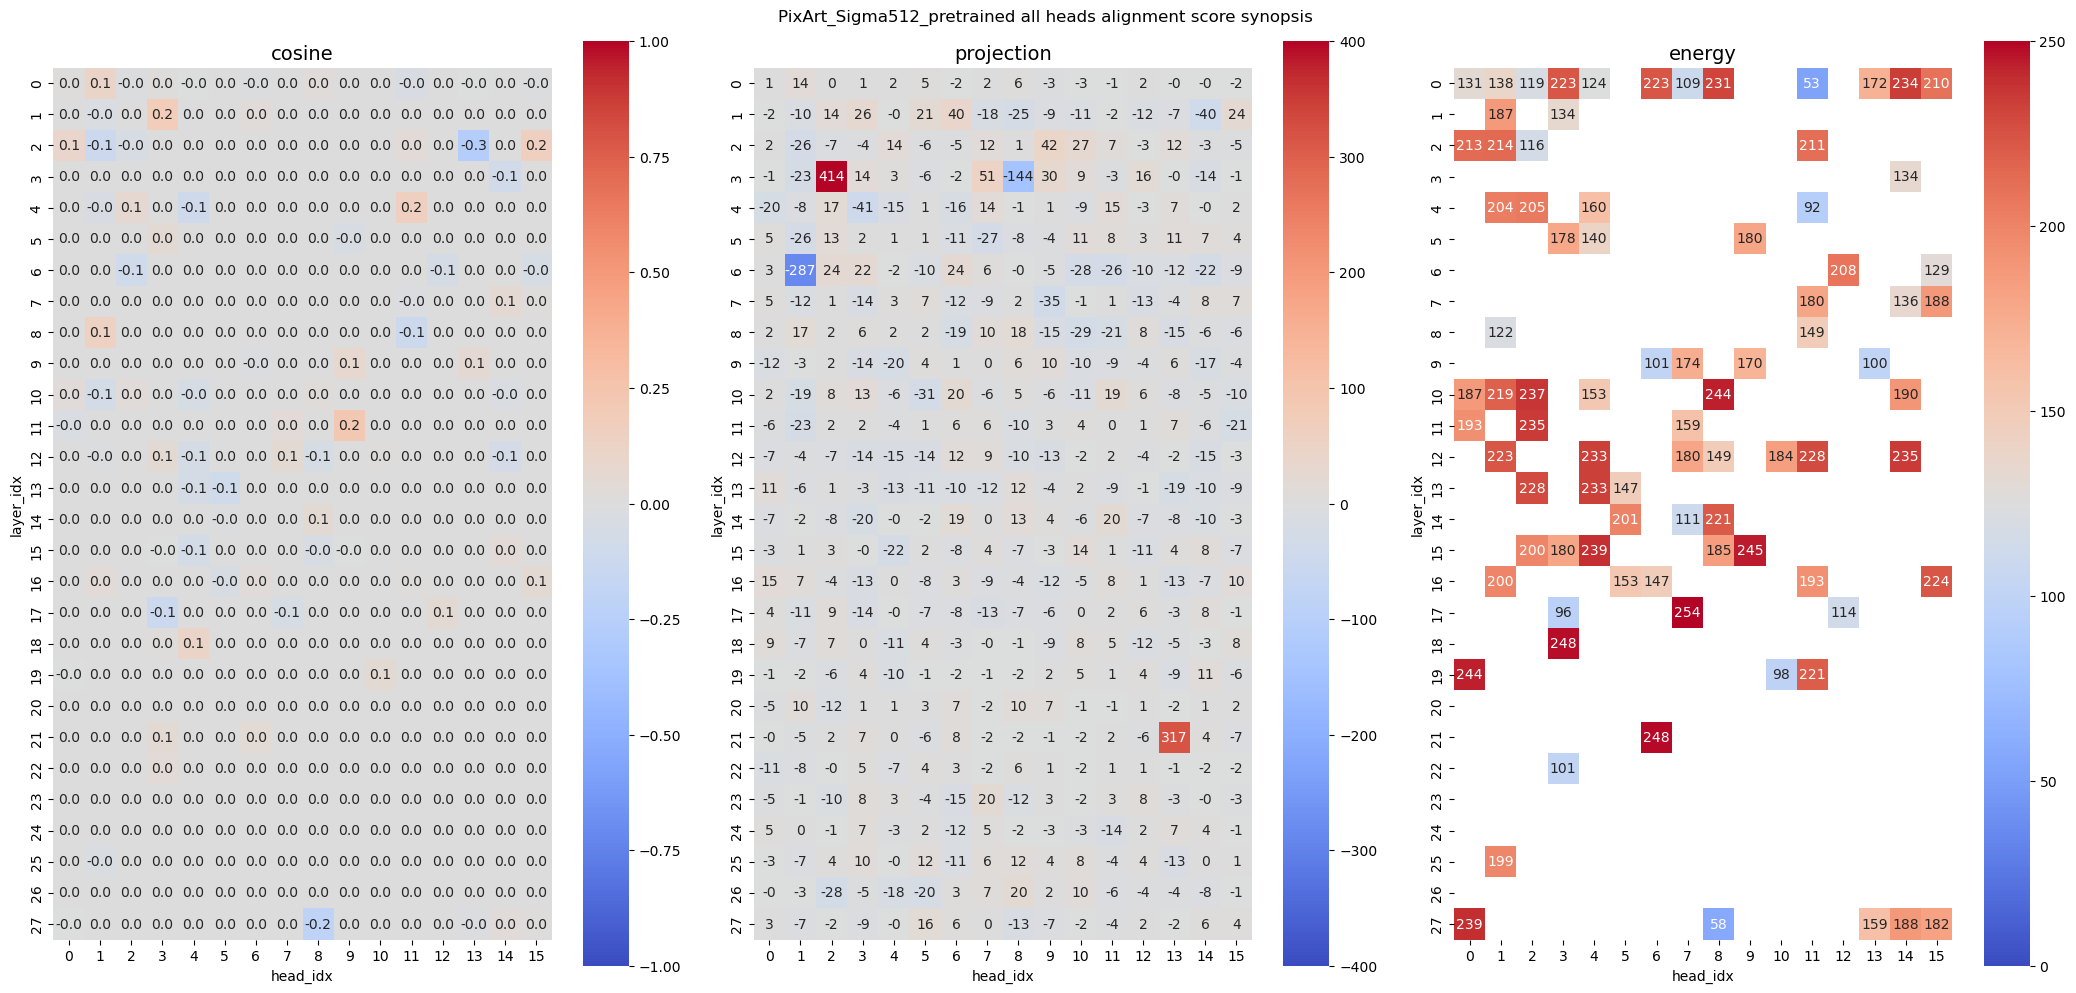

In [63]:
align_df_allheads.to_csv(join(figdir, f"{model_run_name}_align_score_allheads_relation_MLP_proj_rel_factor.csv"), index=False)
head_align_synopsis = align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)
# Plot each column in head_align_synopsis as a heatmap (layers x heads)
metrics = ["cosine", "projection", "energy", ]
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 10), squeeze=False)
for idx, metric, clim, fmt in zip(range(n_metrics), metrics, 
                                  [(-1, 1), (-400, 400), (0, 250)], 
                                  [".1f", ".0f", ".0f"]):
    # reshape values into 2D (layer, head)
    heatmap_data = head_align_synopsis[metric].unstack(level="head_idx")
    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, fmt=fmt, cmap="coolwarm", ax=ax, cbar=True, vmin=clim[0], vmax=clim[1])
    ax.set_aspect("equal")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("head_idx")
    ax.set_ylabel("layer_idx")
plt.suptitle(f"{model_run_name} all heads alignment score synopsis")
plt.tight_layout()
saveallforms(figdir, f"{model_run_name}_all_heads_align_score_synopsis_relation_MLP_proj_rel_factor")
plt.show()

In [88]:
from utils.pixart_utils import PixArt_model_configs
def compute_vis_pos_embed_inner_prod(pipeline, layer_idx, head_idx, feature_vecs, levels_names=None, 
                                   model_run_name="model", device="cuda", visualize=True):
    """
    Visualize the inner product between 2D positional embeddings and target effect vectors for specified head/layer.

    Args:
        layer_idx: int, transformer block index (layer)
        head_idx: int, attention head index
        pipeline: model pipeline with .transformer.transformer_blocks
        effect_vecs: dict of [feature_name] -> np.ndarray (n_level, embed_dim)
        feature: str, which effect_vecs key to use (default: "spatial_relationship")
        model_run_name: str, for titling plots
        levels_map: dict of [feature] -> list of level names (labels for plot)
        device: str, torch device

    Returns: None (creates plot)
    """
    # Get model size info
    # transformer_config = PixArt_model_configs[config.model] if config is not None else PixArt_model_configs["PixArt_B_2"]
    hidden_size = pipe.transformer.config["cross_attention_dim"]
    head_num = pipe.transformer.config['num_attention_heads']
    layer_num = pipe.transformer.config["num_layers"]
    base_size = pipe.transformer.config['sample_size'] // pipe.transformer.config['patch_size']
    head_dim = hidden_size // head_num

    # Target embedding direction
    target_embedding_direction = feature_vecs[:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    # Positional encoding
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().to(device))
    pos_embed_2q_h = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    inner_prod_mat = pos_embed_2q_h @ word_embed_2k_h.T
    if visualize:
        num_levels = len(feature_vecs)
        nrows, ncols = (2, 4) if num_levels == 8 else (1, num_levels)
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
        axs = axs.flatten() if hasattr(axs, "flatten") else [axs]

        for i_word in range(num_levels):
            plt.sca(axs[i_word])
            attn_score = inner_prod_mat[:, i_word:i_word+1]
            plt.imshow(attn_score.view(base_size, base_size).detach().cpu().numpy())
            if levels_names is not None:
                plt.title(f"{levels_names[i_word]}")
            else:
                plt.title(f"{i_word}")
            plt.axis("off")
            plt.colorbar()
        plt.suptitle(f"{model_run_name}\nL{layer_idx}H{head_idx} pos embed inner product with {len(feature_vecs)} factors in Caption Projection")
        # Optionally, save: saveallforms(figdir, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_{feature}_proj")
        plt.tight_layout()
        plt.show()
    else:
        fig = None
    return inner_prod_mat, fig
# Example call (replace indices and other vars as needed):
# 

In [74]:
levels_map["relation"]

array(['left', 'right'], dtype=object)

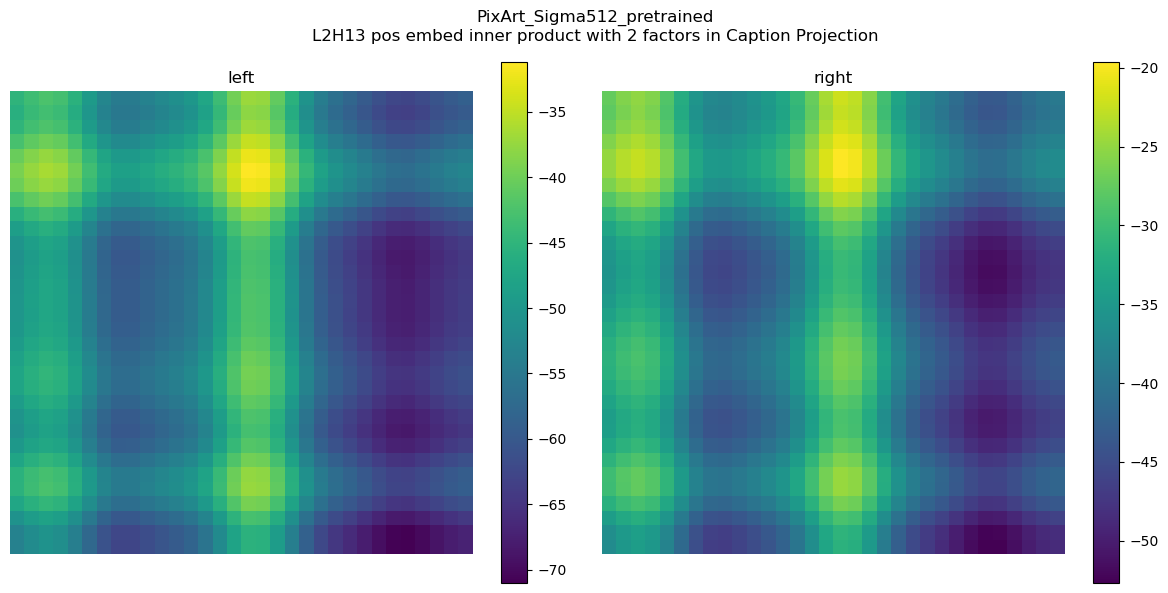

In [73]:
layer_idx, head_idx = 2,13
with torch.no_grad():
    compute_vis_pos_embed_inner_prod(pipe,  layer_idx, head_idx, effect_vecs["relation"], levels_names=levels_map["relation"], 
                                    model_run_name="PixArt_Sigma512_pretrained", device="cuda", visualize=True);

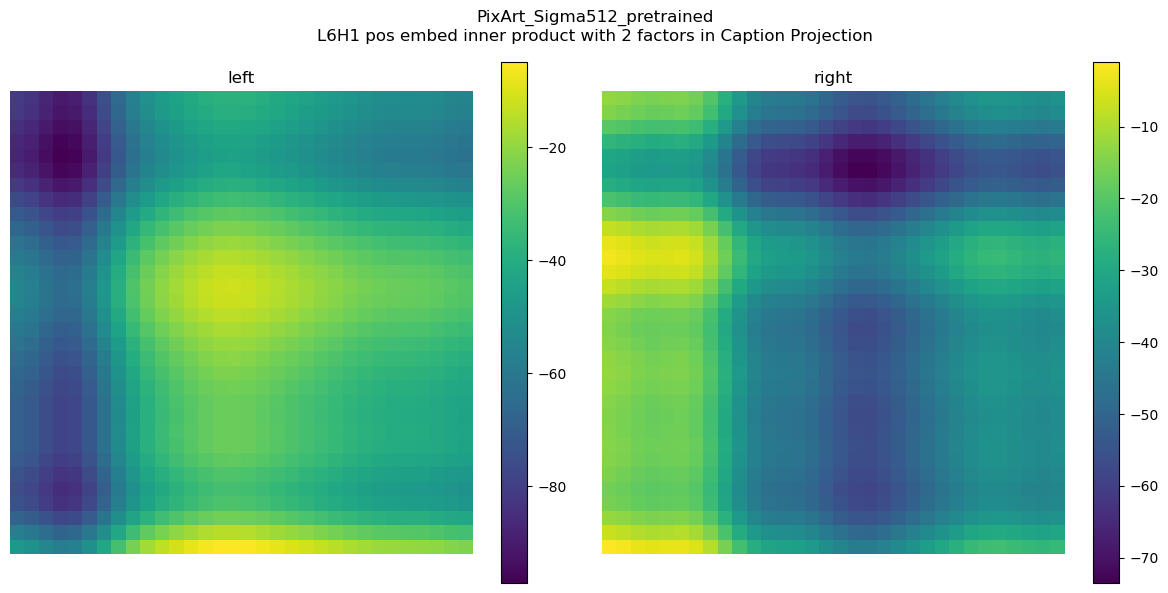

(tensor([[-80.9375, -12.6484],
         [-83.0625, -13.6328],
         [-87.3125, -14.9766],
         ...,
         [-20.5781, -25.2812],
         [-21.7656, -25.7500],
         [-22.5781, -24.8750]], device='cuda:0', dtype=torch.float16,
        grad_fn=<MmBackward0>),
 <Figure size 1200x600 with 4 Axes>)

In [70]:
layer_idx, head_idx = 6,1
compute_vis_pos_embed_inner_prod(pipe,  layer_idx, head_idx, effect_vecs["relation"], levels_names=levels_map["relation"], 
                                model_run_name="PixArt_Sigma512_pretrained", device="cuda", visualize=True)

In [ ]:
df_subset

In [77]:
def extract_projected_wordvecs_from_df(
        df_subset, 
        pipe, 
        device="cuda", 
        max_sequence_length=20
    ):
    """
    For a given dataframe of prompts with columns ['prompt', 'object1', 'relation', 'object2'], 
    returns an edict of (obj1, obj2, relation) word vectors and their projections.

    Args:
        df_subset: DataFrame with at least columns ['prompt','object1','relation','object2']
        pipe: PixArt Sigma pipeline (expects .tokenizer, .text_encoder, .transformer)
        embedding_allrel_allobj: dict mapping `base::{prompt}` to {'caption_embeds':...}
        device: Which device to use for computation ("cuda" or "cpu")
        max_sequence_length: max length for tokenization

    Returns:
        edict with keys:
            'wordvec_obj1_mat', 'wordvec_obj2_mat', 'wordvec_relation_mat',
            'wordvec_obj1_mat_proj', 'wordvec_obj2_mat_proj', 'wordvec_relation_mat_proj'
    """
    import torch
    from easydict import EasyDict as edict

    with torch.no_grad():
        embedding_subset = precompute_embeddings(
            {"base": (df_subset["prompt"], df_subset[["object1", "relation", "object2"]])},
            pipe.tokenizer, pipe.text_encoder, 
            max_sequence_length=max_sequence_length, device=device
        )
    wordvec_obj1_col = []
    wordvec_obj2_col = []
    wordvec_relation_col = []

    for row in df_subset.itertuples():
        tokenized = pipe.tokenizer(
            row.prompt, 
            max_length=max_sequence_length, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        token_ids = tokenized['input_ids'][0]
        tokens = [pipe.tokenizer.decode([token_id]) for token_id in token_ids]

        shape1_mask_idx = find_shape_index(tokens, row.object1)
        if shape1_mask_idx is None:
            print(f"Shape1 ({row.object1}) not found in prompt")
            shape1_mask_idx = find_last_token_of_word(tokens, row.object1)
        shape2_mask_idx = find_shape_index(tokens, row.object2)
        if shape2_mask_idx is None:
            print(f"Shape2 ({row.object2}) not found in prompt")
            shape2_mask_idx = find_last_token_of_word(tokens, row.object2)
        relation_mask_idx = find_shape_index(tokens, row.relation)
        if relation_mask_idx is None:
            print(f"Relation ({row.relation}) not found in prompt")
            relation_mask_idx = find_last_token_of_word(tokens, row.relation)
        if shape1_mask_idx is None or shape2_mask_idx is None or relation_mask_idx is None:
            print(f"Prompt: {row.prompt}")
            print(f"Shape1 ({row.object1}) at index: {shape1_mask_idx}")
            print(f"Shape2 ({row.object2}) at index: {shape2_mask_idx}")
            print(f"Relation ({row.relation}) at index: {relation_mask_idx}")
            print("---")
            raise ValueError("Shape or relation index not found in prompt tokens")
        cap_embeds = embedding_subset[f"base::{row.prompt}"]['caption_embeds']
        wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
        wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
        wordvec_relation_col.append(cap_embeds[0, relation_mask_idx, :])
    wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
    wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)
    wordvec_relation_mat = torch.stack(wordvec_relation_col, dim=0)
    with torch.no_grad():
        wordvec_obj1_mat_proj = pipe.transformer.caption_projection(wordvec_obj1_mat.half().to(device))
        wordvec_obj2_mat_proj = pipe.transformer.caption_projection(wordvec_obj2_mat.half().to(device))
        wordvec_relation_mat_proj = pipe.transformer.caption_projection(wordvec_relation_mat.half().to(device))
    return edict(
        prompt_scene_info_all_df=df_subset,
        wordvec_obj1_mat=wordvec_obj1_mat,
        wordvec_obj2_mat=wordvec_obj2_mat,
        wordvec_relation_mat=wordvec_relation_mat,
        wordvec_obj1_mat_proj=wordvec_obj1_mat_proj,
        wordvec_obj2_mat_proj=wordvec_obj2_mat_proj,
        wordvec_relation_mat_proj=wordvec_relation_mat_proj,
    )

In [78]:
subset_embeds = extract_projected_wordvecs_from_df(df_subset, pipe, device="cuda", max_sequence_length=20)

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/25 [00:00<?, ?it/s]

Cached embeddings for 25 unique prompts (including uncond)


In [80]:
subset_embeds.prompt_scene_info_all_df["left_object"] = subset_embeds.prompt_scene_info_all_df.apply(
    lambda row: row.object1 if row.relation == "left" else row.object2, axis=1)
subset_embeds.prompt_scene_info_all_df["right_object"] = subset_embeds.prompt_scene_info_all_df.apply(
    lambda row: row.object2 if row.relation == "left" else row.object1, axis=1)
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(subset_embeds.wordvec_relation_mat_proj.float().cpu().numpy(),
            {
             "relation": subset_embeds.prompt_scene_info_all_df["relation"],
             "object2": subset_embeds.prompt_scene_info_all_df["object2"],
             "object1": subset_embeds.prompt_scene_info_all_df["object1"],
             "left_object": subset_embeds.prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.925767
Total R² (all features): 0.9258


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,7,94.241385,40.067818,0.425162,40.067818,0.425162,0.851354,0.009901
1,object2,9,8,7,94.241385,41.936717,0.444993,3.472629,0.036848,0.331724,1.000000
2,object1,9,8,7,94.241385,40.563062,0.430417,2.719197,0.028854,0.279897,1.000000
3,left_object,9,8,7,94.241385,36.566549,0.388009,1.845202,0.019580,0.208710,1.000000


In [81]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(subset_embeds.wordvec_obj1_mat_proj.float().cpu().numpy(),
            {
             "relation": subset_embeds.prompt_scene_info_all_df["relation"],
             "object2": subset_embeds.prompt_scene_info_all_df["object2"],
             "object1": subset_embeds.prompt_scene_info_all_df["object1"],
             "left_object": subset_embeds.prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.990698
Total R² (all features): 0.9907


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,object1,9,8,7,372.05409,359.204895,0.965464,40.572204,0.109049,0.921400,0.366337
1,object2,9,8,7,372.05409,314.359956,0.844931,5.460417,0.014676,0.612057,0.970297
2,left_object,9,8,7,372.05409,182.616208,0.490832,1.940653,0.005216,0.359270,1.000000
3,relation,2,1,7,372.05409,1.021366,0.002745,1.021366,0.002745,0.227863,0.079208


In [82]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(subset_embeds.wordvec_obj2_mat_proj.float().cpu().numpy(),
            {
             "relation": subset_embeds.prompt_scene_info_all_df["relation"],
             "object2": subset_embeds.prompt_scene_info_all_df["object2"],
             "object1": subset_embeds.prompt_scene_info_all_df["object1"],
             "left_object": subset_embeds.prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.991128
Total R² (all features): 0.9911


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,object2,9,8,7,381.13894,367.022863,0.962963,44.664789,0.117188,0.929623,0.188119
1,object1,9,8,7,381.13894,319.484073,0.838235,6.716813,0.017623,0.665154,0.910891
2,left_object,9,8,7,381.13894,174.092364,0.456769,1.561884,0.004098,0.315966,1.000000
3,relation,2,1,7,381.13894,0.750251,0.001968,0.750251,0.001968,0.181589,0.148515


In [84]:
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(subset_embeds.wordvec_relation_mat_proj.float().cpu().numpy(),
            {
             "relation": subset_embeds.prompt_scene_info_all_df["relation"],
             "object2": subset_embeds.prompt_scene_info_all_df["object2"],
             "object1": subset_embeds.prompt_scene_info_all_df["object1"],
             "left_object": subset_embeds.prompt_scene_info_all_df["left_object"],
            #  "right_object": prompt_scene_info_all_df["right_object"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.925767
Total R² (all features): 0.9258


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,relation,2,1,7,94.241385,40.067818,0.425162,40.067818,0.425162,0.851354,0.009901
1,object2,9,8,7,94.241385,41.936717,0.444993,3.472629,0.036848,0.331724,1.000000
2,object1,9,8,7,94.241385,40.563062,0.430417,2.719197,0.028854,0.279897,1.000000
3,left_object,9,8,7,94.241385,36.566549,0.388009,1.845202,0.019580,0.208710,1.000000


In [85]:
from tqdm import tqdm
from itertools import product
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

hidden_size = pipe.transformer.config["cross_attention_dim"]
head_num = pipe.transformer.config['num_attention_heads']
layer_num = pipe.transformer.config["num_layers"]
base_size = pipe.transformer.config['sample_size'] // pipe.transformer.config['patch_size']
head_dim = hidden_size // head_num
device = "cuda"
align_df_list = []
for layer_idx, head_idx in tqdm(product(range(layer_num), range(head_num))):
    target_embedding_direction = effect_vecs["relation"][:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipe.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipe.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
    align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["relation"], map_size=(base_size, base_size))
    align_df["layer_idx"] = layer_idx
    align_df["head_idx"] = head_idx
    align_df_list.append(align_df)
align_df_allheads_subset = pd.concat(align_df_list)

448it [00:06, 72.66it/s]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/PixArt_Sigma512_pretrained_attn_head_finding"
# figdir = join(figroot, model_run_name)
os.makedirs(figdir, exist_ok=True)
model_run_name = "PixArt_Sigma512_pretrained"

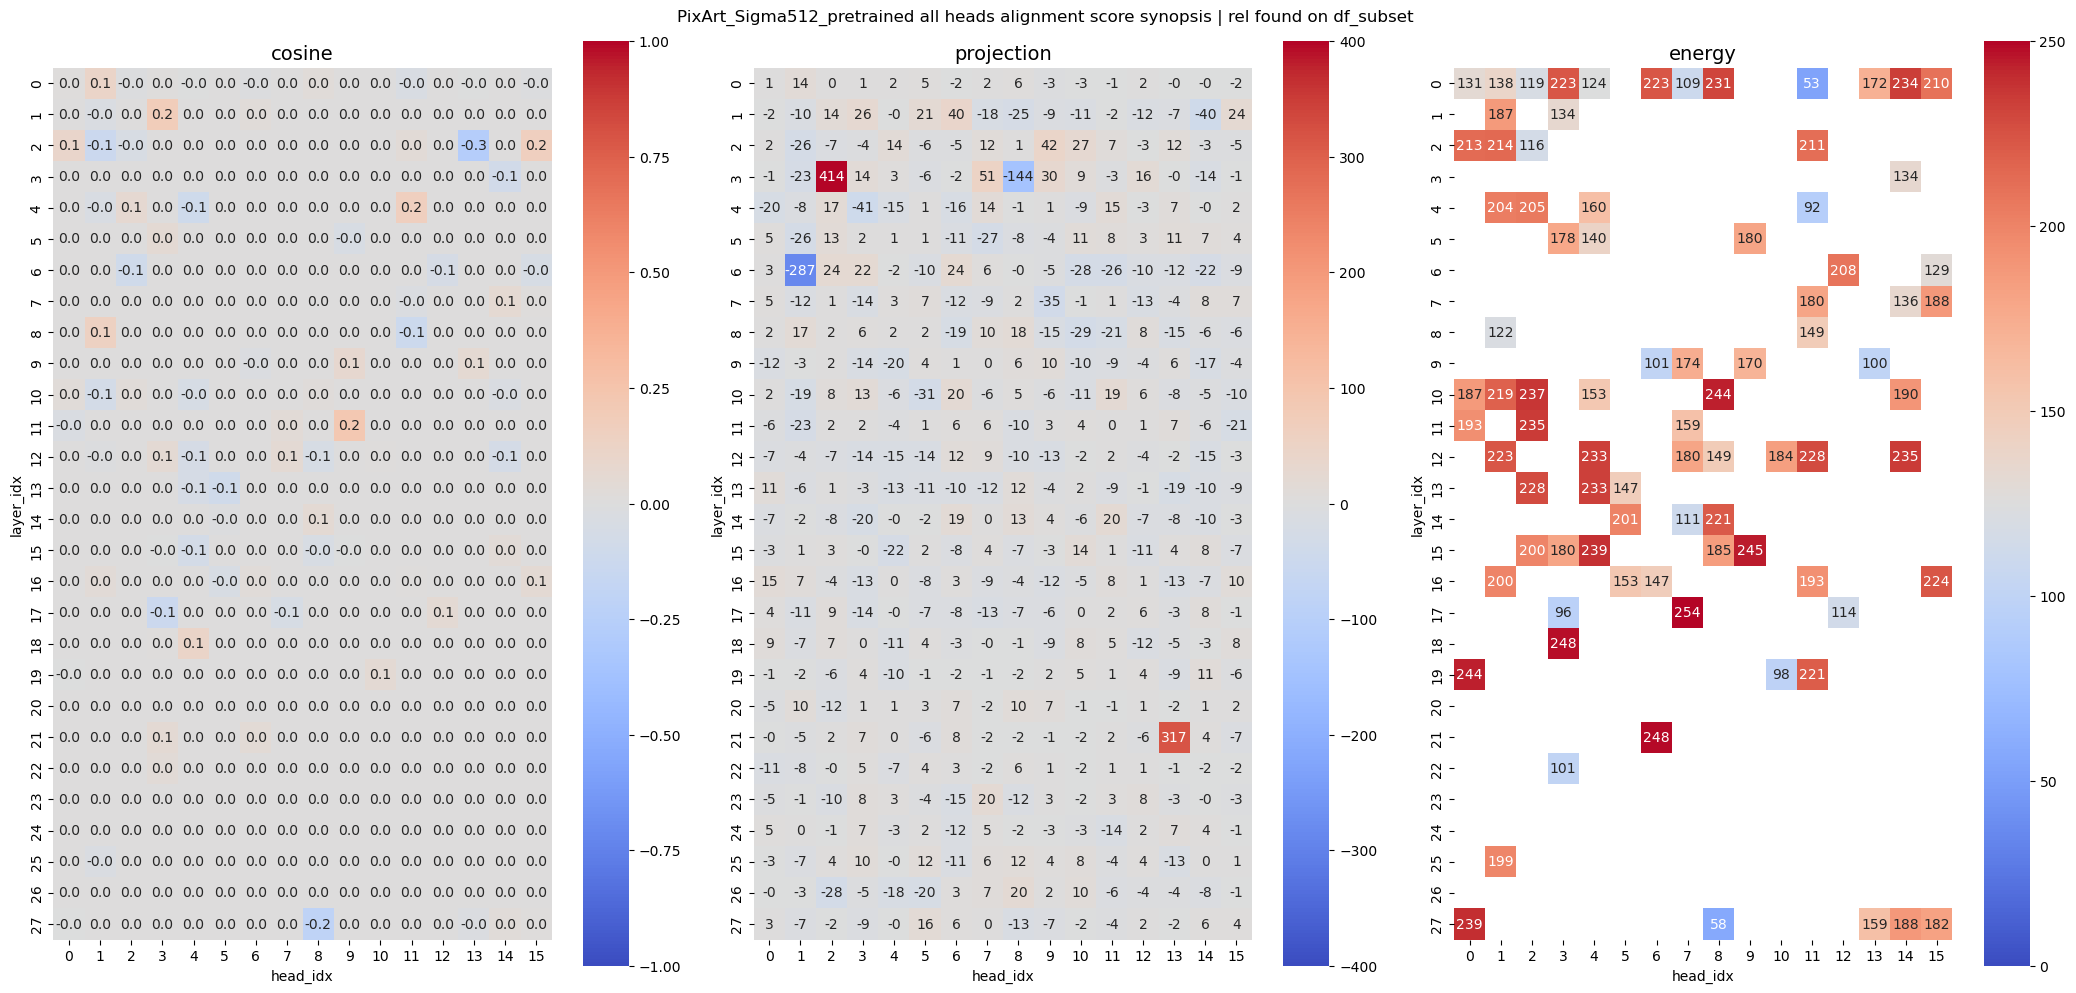

In [86]:
align_df_allheads.to_csv(join(figdir, f"{model_run_name}_align_score_allheads_relation_MLP_proj_rel_factor_df_subset.csv"), index=False)
head_align_synopsis = align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)
# Plot each column in head_align_synopsis as a heatmap (layers x heads)
metrics = ["cosine", "projection", "energy", ]
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 10), squeeze=False)
for idx, metric, clim, fmt in zip(range(n_metrics), metrics, 
                                  [(-1, 1), (-400, 400), (0, 250)], 
                                  [".1f", ".0f", ".0f"]):
    # reshape values into 2D (layer, head)
    heatmap_data = head_align_synopsis[metric].unstack(level="head_idx")
    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, fmt=fmt, cmap="coolwarm", ax=ax, cbar=True, vmin=clim[0], vmax=clim[1])
    ax.set_aspect("equal")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("head_idx")
    ax.set_ylabel("layer_idx")
plt.suptitle(f"{model_run_name} all heads alignment score synopsis | rel found on df_subset" )
plt.tight_layout()
saveallforms(figdir, f"{model_run_name}_all_heads_align_score_synopsis_relation_MLP_proj_rel_factor_df_subset")
plt.show()

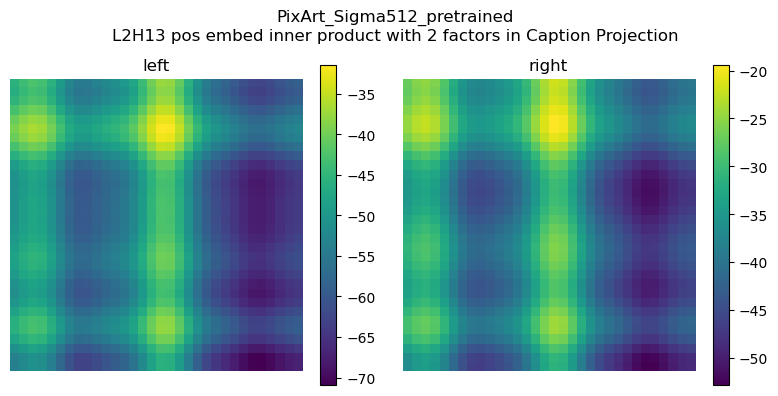

In [91]:
for layer_idx, head_idx in [(2, 13)]:
    compute_vis_pos_embed_inner_prod(pipe,  layer_idx, head_idx, effect_vecs["relation"], levels_names=levels_map["relation"], 
                                    model_run_name="PixArt_Sigma512_pretrained", device="cuda", visualize=True)

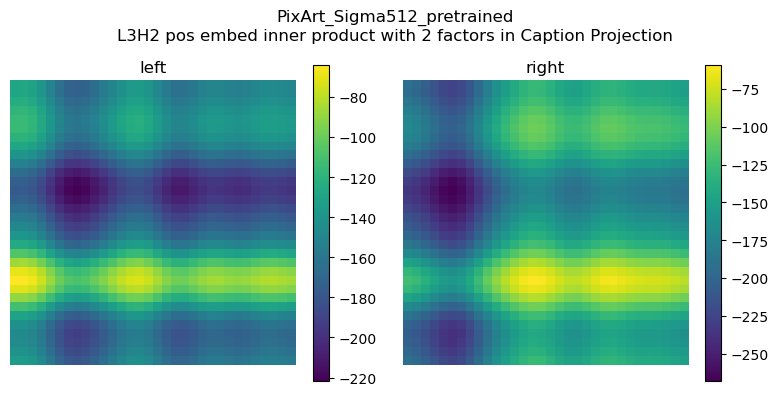

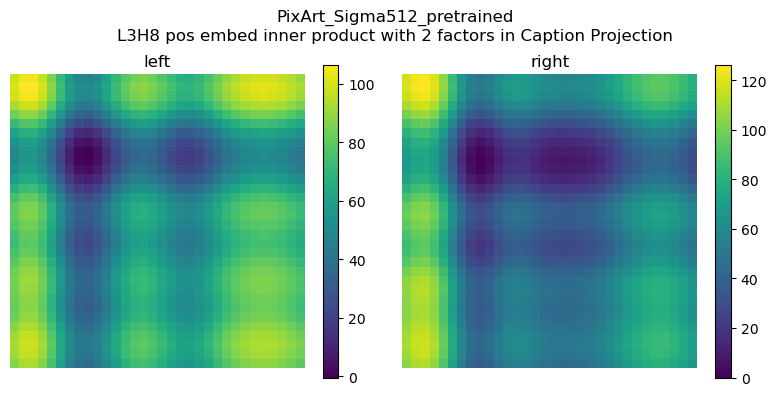

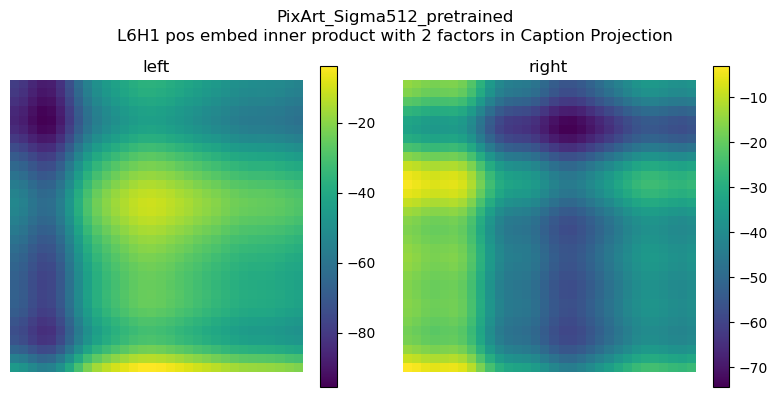

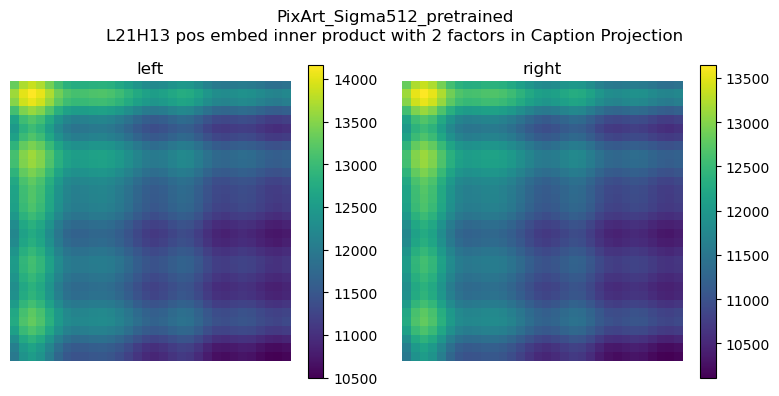

In [89]:
for layer_idx, head_idx in [(3,2), (3,8), (6,1), (21, 13)]:
    compute_vis_pos_embed_inner_prod(pipe,  layer_idx, head_idx, effect_vecs["relation"], levels_names=levels_map["relation"], 
                                    model_run_name="PixArt_Sigma512_pretrained", device="cuda", visualize=True)

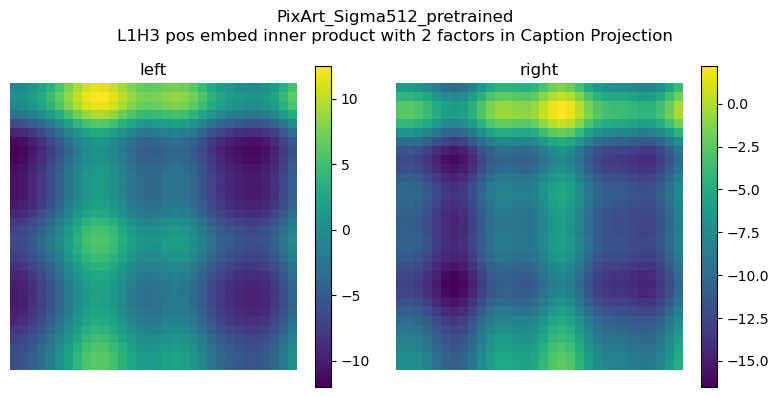

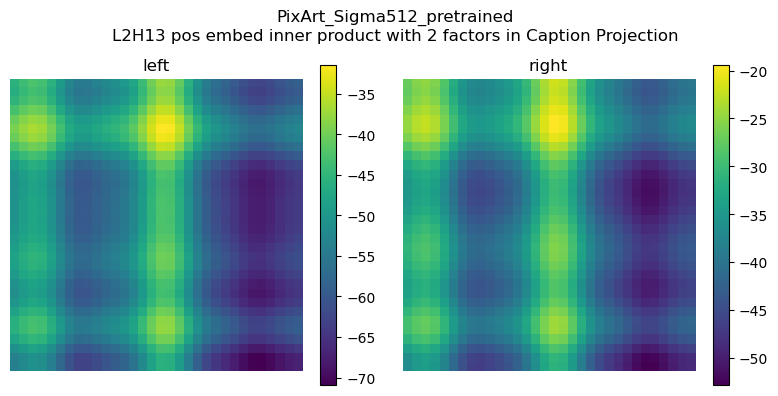

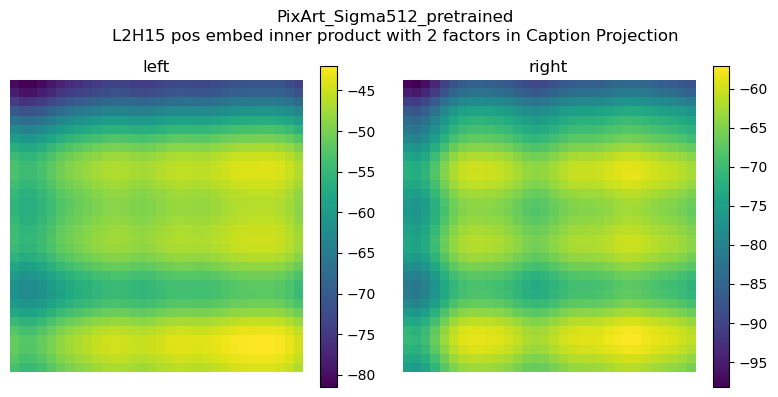

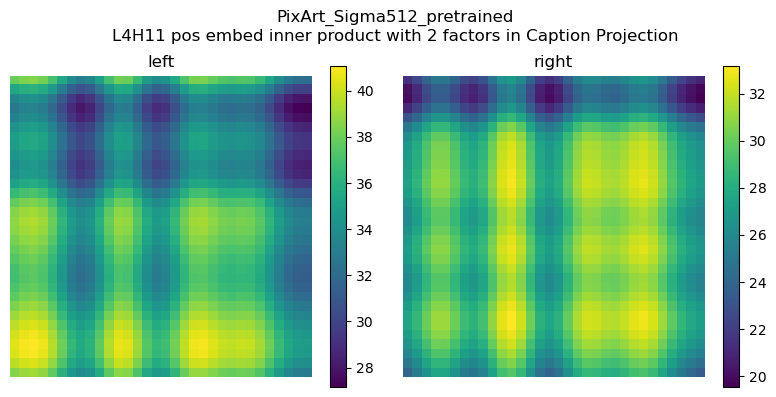

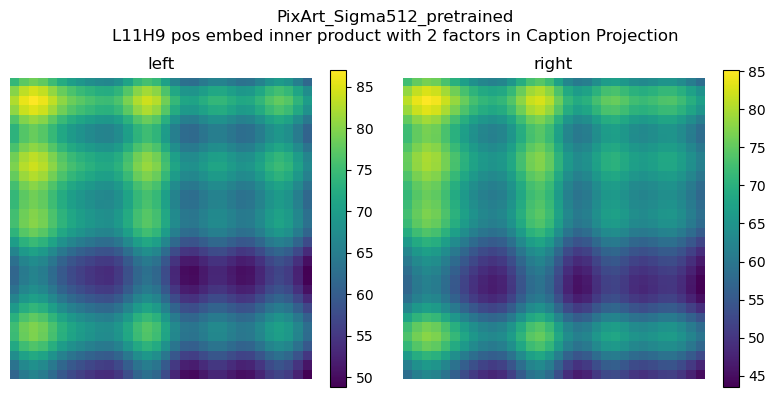

In [92]:
for layer_idx, head_idx in [(1,3), (2,13), (2,15), (4,11), (11, 9)]:
    compute_vis_pos_embed_inner_prod(pipe,  layer_idx, head_idx, effect_vecs["relation"], levels_names=levels_map["relation"], 
                                    model_run_name="PixArt_Sigma512_pretrained", device="cuda", visualize=True)